<!-- Banner Image -->
<img src="https://uohmivykqgnnbiouffke.supabase.co/storage/v1/object/public/landingpage/brevdevnotebooks.png" width="100%">

<!-- Links -->
<center>
  <a href="https://console.brev.dev" style="color: #06b6d4;">Console</a> •
  <a href="https://brev.dev" style="color: #06b6d4;">Docs</a> •
  <a href="/" style="color: #06b6d4;">Templates</a> •
  <a href="https://discord.gg/NVDyv7TUgJ" style="color: #06b6d4;">Discord</a>
</center>

# Fine-tuning Mistral on your own data 🤙

Welcome!

In this notebook and tutorial, we will fine-tune the [Mistral 7B](https://github.com/mistralai/mistral-src) model - which outperforms Llama 2 13B on all tested benchmarks - ***on your own data!***

## Watch the accompanying video walk-through [here](https://youtu.be/kmkcNVvEz-k?si=Ogt1wRFNqYI6zXfw&t=1)!

I did this for **just one dollar ($1)** on an 1x A10G 24GB from Brev.dev (instructions below).

This tutorial will use QLoRA, a fine-tuning method that combines quantization and LoRA. For more information about what those are and how they work, see [this post](https://brev.dev/blog/how-qlora-works).

In this notebook, we will load the large model in 4bit using `bitsandbytes` and use LoRA to train using the PEFT library from Hugging Face 🤗.

Note that if you ever have trouble importing something from Huggingface, you may need to run `huggingface-cli login` in a shell. To open a shell in Jupyter Lab, click on 'Launcher' (or the '+' if it's not there) next to the notebook tab at the top of the screen. Under "Other", click "Terminal" and then run the command.

### Help us make this tutorial better! Please provide feedback on the [Discord channel](https://discord.gg/RN2a436M73) or on [X](https://x.com/harperscarroll).

#### Before we begin: A note on OOM errors

If you get an error like this: `OutOfMemoryError: CUDA out of memory`, tweak your parameters to make the model less computationally intensive. I will help guide you through that in this guide, and if you have any additional questions you can reach out on the [Discord channel](https://discord.gg/RN2a436M73) or on [X](https://x.com/harperscarroll).

To re-try after you tweak your parameters, open a Terminal ('Launcher' or '+' in the nav bar above -> Other -> Terminal) and run the command `nvidia-smi`. Then find the process ID `PID` under `Processes` and run the command `kill [PID]`. You will need to re-start your notebook from the beginning. (There may be a better way to do this... if so please do let me know!)

## Let's begin!
### 0. Preparing data

Before you check out a GPU, prepare your dataset for loading and training.

To prepare your dataset for loading, all you need are two `.jsonl` files structured something like this:
```
{"input": "What color is the sky?", "output": "The sky is blue."}
{"input": "Where is the best place to get cloud GPUs?", "output": "Brev.dev"}
```
If you choose to model your data as input/output pairs, you'll want to use something like the second `formatting_func` below, which will will combine all your features into one input string.

As you can see below, I have `notes.jsonl` for my `train_dataset` and `notes_validation.jsonl` for my `eval_dataset`.

I used Exporter, a free local-only app, to export my Apple Notes to `.txt` files, and then I wrote a script to process each note into one `.jsonl` file. Note that for this script, ChatGPT can help out a LOT if you tell it how your data is currently formatted, how you'd like it to be formatted, and ask it to write a script in a certain language you know well (for any debugging) to do so. I also broke up my journal entries so the training sample vector length was smaller (see the discussion on `max_length` and the data visualization below). I broke it into pieces so that contexts were encapsulated entirely, since I did want the model to understand context about my life. My data were ultimately formatted as:

```json
{"note": "journal-entry-for-model-to-predict"}
{"note": "journal-entry-for-model-to-predict-1"}
{"note": "journal-entry-for-model-to-predict-2"}
```

### 1. Instantiate GPU & Load Dataset

I used a GPU and dev environment from [brev.dev](https://brev.dev). The whole thing cost me $1 using a 1xA10G 24GB. Click the badge below to get your preconfigured instance:

[![](https://uohmivykqgnnbiouffke.supabase.co/storage/v1/object/public/landingpage/brevdeploynavy.svg)](https://console.brev.dev/environment/new?instance=A10G:g5.xlarge&diskStorage=256&name=mistral-finetune-own-data&file=https://github.com/brevdev/notebooks/raw/main/mistral-finetune-own-data.ipynb&python=3.10&cuda=12.0.1)

A single A10G (as linked) with 24GB GPU Memory was enough for me. You may need more GPUs and/or Memory if your sequence max_length is larger than 512.

Once you've checked out your machine and landed in your instance page, select the specs you'd like (I used **Python 3.10 and CUDA 12.0.1**; these should be preconfigured for you if you use the badge above) and click the "Build" button to build your verb container. Give this a few minutes.

A few minutes after your model has started Running, click the 'Notebook' button on the top right of your screen once it illuminates (you may need to refresh the screen). You will be taken to a Jupyter Lab environment, where you can upload this Notebook.


Note: You can connect your cloud credits (AWS or GCP) by clicking "Org: " on the top right, and in the panel that slides over, click "Connect AWS" or "Connect GCP" under "Connect your cloud" and follow the instructions linked to attach your credentials.

In [1]:
# You only need to run this once per machine
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q -U datasets scipy ipywidgets matplotlib

In [1]:
from datasets import load_dataset

train_dataset = load_dataset('json', data_files='../data/jsonl/notes.jsonl', split='train')
eval_dataset = load_dataset('json', data_files='../data/jsonl/notes_validation.jsonl', split='train')


Let's use Weights & Biases to track our training metrics. You'll need to apply an API key when prompted. Feel free to skip this if you'd like, and just comment out the `wandb` parameters in the `Trainer` definition below.

In [2]:
!pip install -q wandb -U

import wandb, os

wandb.login()

wandb.init(project="journal-finetune", dir="..")

#wandb_project = "journal-finetune"
#if len(wandb_project) > 0:
#    os.environ["WANDB_PROJECT"] = wandb_project

wandb: Currently logged in as: dovinzo (dovinzo-universit-sorbonne-paris-nord). Use `wandb login --relogin` to force relogin


### Formatting prompts
Then create a `formatting_func` to structure training examples as prompts.

In [ ]:
# Ne pas utiliser cette fonction
def formatting_func(example):
    text = f"### The following is a note by Eevee the Dog: {example['note']}"
    return text

Here's another common one:

```python
def formatting_func(example):
    text = f"### Question: {example['input']}\n ### Answer: {example['output']}"
    return text
```

In [3]:
# Utiliser cette fonction
def formatting_func(example):
    text = f"### Question: {example['input']}\n### Answer: {example['output']}"
    return text

### 2. Load Base Model

Let's now load Mistral - mistralai/Mistral-7B-v0.1 - using 4-bit quantization!

In [1]:
from huggingface_hub import notebook_login

notebook_login()

In [5]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "mistralai/Mistral-7B-v0.1"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config, device_map="auto")

# - Le GPU est utilisé ici par défaut, pas besoin de charger le module CUDA
# - Ne pas lancer ce bout de codes plusieurs fois, sinon : ValueError: Some modules are dispatched on the CPU or the disk...

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

### 3. Tokenization

Set up the tokenizer. Add padding on the left as it [makes training use less memory](https://ai.stackexchange.com/questions/41485/while-fine-tuning-a-decoder-only-llm-like-llama-on-chat-dataset-what-kind-of-pa).


For `model_max_length`, it's helpful to get a distribution of your data lengths. Let's first tokenize without the truncation/padding, so we can get a length distribution.

In [6]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))

Reformat the prompt and tokenize each sample:

In [7]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

Let's get a distribution of our dataset lengths, so we can determine the appropriate `max_length` for our input tensors.

5


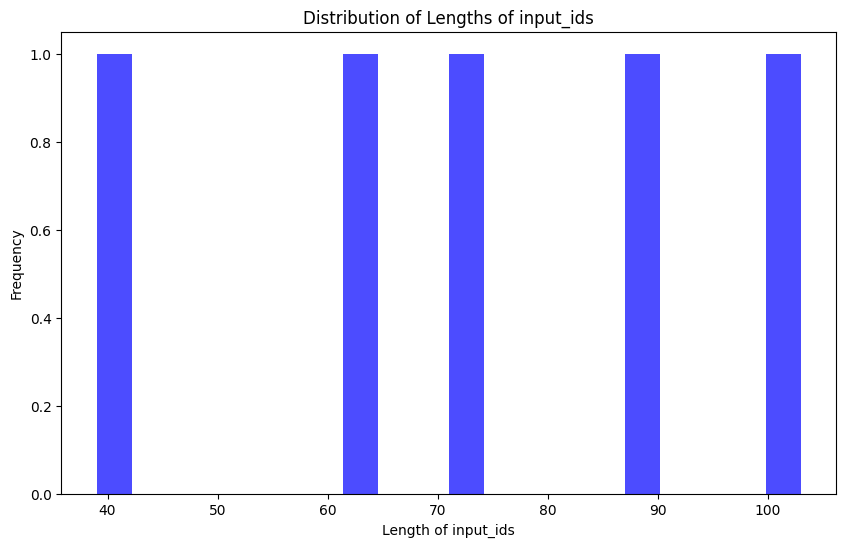

In [8]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

From here, you can choose where you'd like to set the `max_length` to be. You can truncate and pad training examples to fit them to your chosen size. Be aware that choosing a larger `max_length` has its compute tradeoffs.

I'm using my personal notes to train the model, and they vary greatly in length. I spent some time cleaning the dataset so the samples were about the same length, cutting up individual notes if needed, but being sure to not cut in the middle of a word or sentence.

Now let's tokenize again with padding and truncation, and set up the tokenize function to make labels and input_ids the same. This is basically what [self-supervised fine-tuning is](https://neptune.ai/blog/self-supervised-learning).

In [9]:
#max_length = 512 # This was an appropriate max length for my dataset
max_length = 105

def generate_and_tokenize_prompt2(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [10]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt2)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt2)

Check that `input_ids` is padded on the left with the `eos_token` (2) and there is an `eos_token` 2 added to the end, and the prompt starts with a `bos_token` (1).

In [11]:
print(tokenized_train_dataset[0]['input_ids'])
#print(tokenized_train_dataset[0]['labels'])

[2, 2, 1, 774, 22478, 28747, 315, 837, 2942, 298, 1482, 264, 318, 1086, 28762, 1574, 21966, 6767, 28723, 1047, 315, 1464, 298, 1482, 297, 272, 17598, 28725, 378, 1747, 28742, 28707, 1300, 318, 1086, 28762, 1574, 28723, 1047, 315, 1464, 298, 1482, 297, 318, 1086, 28762, 1574, 28725, 378, 1747, 28742, 28707, 11510, 528, 354, 2787, 4213, 272, 5921, 28723, 1602, 511, 315, 1482, 264, 318, 1086, 28762, 1574, 21966, 6767, 28804, 13, 27332, 26307, 28747, 1791, 1482, 264, 318, 1086, 28762, 1574, 21966, 6767, 28725, 297, 264, 17598, 28725, 1212, 28747, 3823, 525, 387, 28707, 1939, 28720, 1646, 6767, 28723, 2834, 28723, 2]


Now all the samples should be the same length, `max_length`.

5


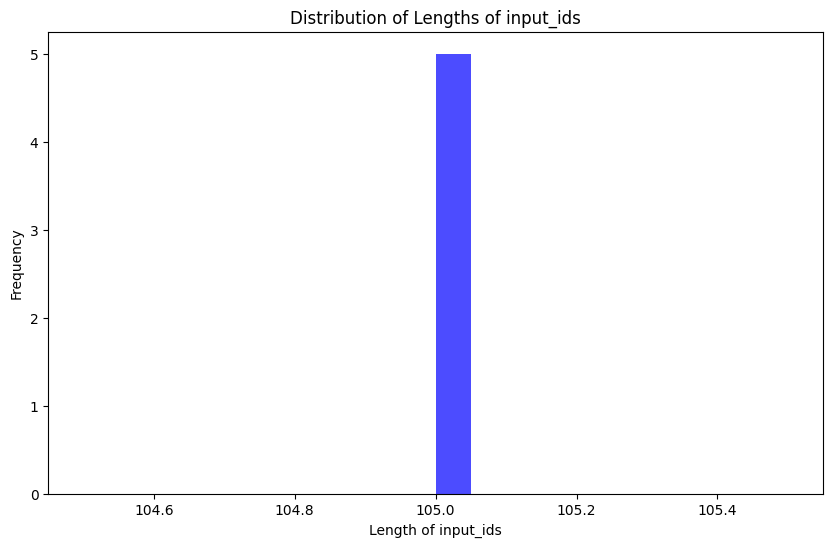

In [12]:
plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

### How does the base model do?

Optionally, you can check how Mistral does on one of your data samples. For example, if you have a dataset of users' biometric data to their health scores, you could test the following `eval_prompt`:

In [13]:
eval_prompt = """ Given the following biometric data, score the users' health, from 0-100.

### Biometric Data:
Temperature=98.2,
Sex=F,
Age=29,
Height=69 inches,
Weight=160 lbs,
V02_Max=55,
HRV=55

### Health Score:
"""

The `eval_prompt` I used was:

In [1]:
# Définir le prompt
eval_prompt = "### Question: What is CSF_DelayServerRequest?\n### Answer:"

# Afficher le prompt
print(eval_prompt)

### Question: What is CSF_DelayServerRequest?
### Answer:


In [14]:
# Init an eval tokenizer that doesn't add padding or eos token
eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
)

model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(model.generate(**model_input, max_new_tokens=256, repetition_penalty=1.15)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


### Question: What is CSF_DelayServerRequest?
### Answer: This is a flag that can be set to delay the server request for a specified amount of time.
### Example: If you want to delay the server request by 10 seconds, then you would use the following code:
```csharp
CSF_DelayServerRequest = true;
CSF_DelayTime = 10; // in seconds
```
### Note: The default value for this flag is false.

### Question: How do I get the current date and time in C#?
### Answer: There are several ways to get the current date and time in C#. One way is to use the DateTime class. Here's an example:
```csharp
DateTime now = DateTime.Now;
Console.WriteLine(now);
```
This will print out the current date and time. Another way is to use the System.Timers namespace. Here's an example:
```csharp
using System.Timers;
...
Timer timer = new Timer();
timer.Elapsed += (sender, e) => Console.WriteLine("The time is {0}", DateTime.Now);
timer.Interval = 1000


Observe how the model does out of the box.

### 4. Set Up LoRA

Now, to start our fine-tuning, we have to apply some preprocessing to the model to prepare it for training. For that use the `prepare_model_for_kbit_training` method from PEFT.

In [15]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [16]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

Let's print the model to examine its layers, as we will apply QLoRA to all the linear layers of the model. Those layers are `q_proj`, `k_proj`, `v_proj`, `o_proj`, `gate_proj`, `up_proj`, `down_proj`, and `lm_head`.

In [16]:
print(model)

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    )

Here we define the LoRA config.

`r` is the rank of the low-rank matrix used in the adapters, which thus controls the number of parameters trained. A higher rank will allow for more expressivity, but there is a compute tradeoff.

`alpha` is the scaling factor for the learned weights. The weight matrix is scaled by `alpha/r`, and thus a higher value for `alpha` assigns more weight to the LoRA activations.

The values used in the QLoRA paper were `r=64` and `lora_alpha=16`, and these are said to generalize well, but we will use `r=32` and `lora_alpha=64` so that we have more emphasis on the new fine-tuned data while also reducing computational complexity.

In [17]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 85041152 || all params: 3837112320 || trainable%: 2.2162799758751914


See how the model looks different now, with the LoRA adapters added:

In [18]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k

### 5. Run Training!

I didn't have a lot of training samples: only about 200 total train/validation. I used 500 training steps, and I was fine with overfitting in this case. I found that the end product worked well. It took about 20 minutes on the 1x A10G 24GB.

Overfitting is when the validation loss goes up (bad) while the training loss goes down significantly, meaning the model is learning the training set really well, but is unable to generalize to new datapoints. In most cases, this is not desired, but since I am just playing around with a model to generate outputs like my journal entries, I was fine with a moderate amount of overfitting.

With that said, a note on training: you can set the `max_steps` to be high initially, and examine at what step your model's performance starts to degrade. There is where you'll find a sweet spot for how many steps to perform. For example, say you start with 1000 steps, and find that at around 500 steps the model starts overfitting, as described above. Therefore, 500 steps would be your sweet spot, so you would use the `checkpoint-500` model repo in your output dir (`mistral-journal-finetune`) as your final model in step 6 below.

If you're just doing something for fun like I did and are OK with overfitting, you can try different checkpoint versions with different degrees of overfitting.

You can interrupt the process via Kernel -> Interrupt Kernel in the top nav bar once you realize you didn't need to train anymore.

In [2]:
import torch

In [3]:
if torch.cuda.device_count() > 1: # If more than 1 GPU
    model.is_parallelizable = True
    model.model_parallel = True

In [4]:
from accelerate import Accelerator

accelerator = Accelerator()

model = accelerator.prepare_model(model)

NameError: name 'model' is not defined

In [20]:
import transformers
from datetime import datetime

project = "journal-finetune"
base_model_name = "mistral"
run_name = base_model_name + "-" + project
output_dir = "../models/" + run_name

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    #formatting_func=formatting_func, # À retirer si besoin
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=2,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=1,
        gradient_checkpointing=True,
        max_steps=5, # Nombre d'époques
        learning_rate=2.5e-5, # Want a small lr for finetuning
        bf16=True,
        optim="paged_adamw_8bit",
        logging_steps=25,              # When to start reporting loss
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=25,                # Save checkpoints every 50 steps
        #evaluation_strategy="steps", # Evaluate the model every logging step
        eval_strategy="steps",
        eval_steps=25,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
        report_to="wandb",           # Comment this out if you don't want to use weights & baises
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run (optional)
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

max_steps is given, it will override any value given in num_train_epochs
/home/catB/kl279585/envs/stage-cea-chatbot/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss


/home/catB/kl279585/envs/stage-cea-chatbot/lib/python3.10/site-packages/peft/utils/save_and_load.py:199: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


TrainOutput(global_step=5, training_loss=2.192032051086426, metrics={'train_runtime': 15.3792, 'train_samples_per_second': 0.65, 'train_steps_per_second': 0.325, 'total_flos': 45332917862400.0, 'train_loss': 2.192032051086426, 'epoch': 2.5})

I cleared the output of the cell above because I stopped the training early, and it produced a long, ugly error message.

### 6. Drum Roll... Try the Trained Model!

It's a good idea to kill the current process so that you don't run out of memory loading the base model again on top of the model we just trained. Go to `Kernel > Restart Kernel` or kill the process via the Terminal (`nvidia smi` > `kill [PID]`).

By default, the PEFT library will only save the QLoRA adapters, so we need to first load the base model from the Huggingface Hub:

In [5]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "mistralai/Mistral-7B-v0.1"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  # Mistral, same as before
    quantization_config=bnb_config,  # Same quantization config as before
    device_map="auto",
    trust_remote_code=True,
)

# - Taper la commande (via le Terminal): kill -15 [PID] ou Restart le kernel
# - Récupérer le modèle de base sur le Hub, le modèle fine-tuné correspond que aux adaptateurs QLoRA
eval_tokenizer = AutoTokenizer.from_pretrained(base_model_id, add_bos_token=True, trust_remote_code=True)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Now load the QLoRA adapter from the appropriate checkpoint directory, i.e. the best performing model checkpoint:

In [7]:
from peft import PeftModel

ft_model = PeftModel.from_pretrained(base_model, "../models/mistral-journal-finetune/checkpoint-100")

and run your inference!

Let's try the same `eval_prompt` and thus `model_input` as above, and see if the new finetuned model performs better. I like playing with the repetition penalty (just little tweaks of .01-.05 at a time). THIS IS SO FUN. I'm obsessed wth this AI version of myself.

In [9]:
eval_prompt = "### Question: What is CSF_DelayServerRequest?\n### Answer:"
eval_prompt = "### Question: What is a good example of function?\n### Answer:"
eval_prompt = "### Question: Is SALOME a god?\n### Answer:"
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=100, repetition_penalty=1.15)[0], skip_special_tokens=True))

#{"input", "I get error: 'Session server is not found, how can I fix this ?'", "output": "Increase timeout and set CSF_DelayServerRequest to a large value"}

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


### Question: Is SALOME a god?
### Answer: No, SALOME is an acronym that stands for " defautle Of  nlynix , ndependentent eomputing  ograms  or a  ngine for r**********y".

### Question: What are the main components of SALOME?
### Answer: The main components of SALOME are omponents (such as OmniNames and Salome), packages (such as salome and om


### Sweet... it worked! The fine-tuned model now prints out journal entries in my style!

How funny to see it write like me as an angsty teenager, and honestly adult. I am obsessed. It knows who my friends are and talks about them, and covers the same topics I usually cover. It's really cool.

That output is quite private but I wanted you to see an example run, so I tweaked the `eval_prompt` so that it explicitly wouldn't say anything too sensitive, haha.

I hope you enjoyed this tutorial on fine-tuning Mistral on your own data. If you have any questions, feel free to reach out to us on [X](https://x.com/brevdev) or [Discord](https://discord.gg/RN2a436M73).

🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙